In [2]:
import re
import json
import itertools
import scipy as sp
import numpy as np
import pandas as pd
import dask.bag as db
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import accuracy_score, roc_curve, auc, hamming_loss

'''variables: year, cat1, cat2'''
'''structure: Data preprocessing + Topic extraction with LatentDirichletAllocation'''

# Extract common elements from multiple lists
def extra_same_elem(lst, lst2):

    iset = set(lst)
    s = set(lst2)
    iset = iset.intersection(s)

    return list(iset)

# get top words
def top_words_data_frame(model: LatentDirichletAllocation, tf_idf_vectorizer: TfidfVectorizer, n_top_words: int) -> pd.DataFrame:

    rows = []
    feature_names = tf_idf_vectorizer.get_feature_names()

    for topic in model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        rows.append(top_words)

    columns = [f'topic {i+1}' for i in range(n_top_words)]
    df = pd.DataFrame(rows, columns=columns)

    return df

# Function to plot the most relevant words
def plot_top_words(model, feature_names, n_top_words, title):
    
    fig, axes = plt.subplots(1, 2, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
            
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# select year for data set
def LDA_2_select_year(year1, year2):

    # use dask.bag to load json file
    docs = db.read_text('/Users/maoyiting/repository/M4R/arxiv-data/arxiv-metadata-oai-snapshot.json').map(json.loads)

    # Submissions by datetime
    get_year = lambda x: x['versions'][-1]['created'].split(' ')[3]

    # get only necessary fields
    trim = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],
                      'time':x['versions'][-1]['created'].split(' ')[3]}

    # filter for papers published on or after ????-01-01
    docs_df = (docs.filter(lambda x: int(get_year(x)) > year1)
                   .filter(lambda x: int(get_year(x)) < year2)
                   .map(trim)
                   .compute())

    # convert to pandas dataframe
    docs_df = pd.DataFrame(docs_df)

    # add main category
    docs_df['main_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x][0].split())
    
    # add main category 2 
    docs_df['main_category2'] = docs_df.main_category.apply(lambda x: x[0])

    # discard categories with number of samples < 500
    d = {'cat':docs_df['main_category2'].value_counts().index, 'count': docs_df['main_category2'].value_counts()}
    df_cat = pd.DataFrame(data=d).reset_index(drop=True)
    df_cat.drop(df_cat[df_cat['count']<500].index)
    discard_cat = df_cat[df_cat['count']<500].cat.tolist()
    docs_df = docs_df.drop(docs_df[(docs_df.main_category2.apply(lambda x: x in discard_cat)==True)].index)

    # find all categories
    cat_list = docs_df['main_category2'].unique()

    return docs_df, cat_list


# select categories
def LDA_2_select_categories(docs_df, cat_list, n_topics, num_cal):

    #num = 19
    # get all the combinations for categories
    #list_2 = list(itertools.combinations(cat_list, 2))
    list_2 = [('math', 'cs'), 
              ('cond-mat', 'math'),
              ('cond-mat', 'cs'),
              ('astro-ph', 'cs'),
              ('cs', 'stat'),
              ('math', 'math-ph'),
              ('physics', 'hep-ex'),
              ('nlin', 'q-fin'),
              ('hep-ph', 'gr-qc'),
              ('nucl-th', 'q-bio')]

    m = len(list_2)

    # initialize accuracy, var
    acc = np.zeros(num_cal)
    std = np.zeros(num_cal)
    num = np.zeros(num_cal)

    for i in range(num_cal):
        print('pair',i)

        # define two categories
        cat1 = list_2[i][0]
        cat2 = list_2[i][1]

        # filter for papers in 'cat1' or 'cat2' area
        docs_df2 = docs_df[(docs_df.main_category.apply(lambda x: cat1 in x )==True)|(docs_df.main_category.apply(lambda x: cat2 in x )==True)]

        # convert general category into label columns
        mlb = MultiLabelBinarizer()
        labels = mlb.fit_transform(docs_df2.main_category)

        # concatenate with the abstracts
        df = pd.concat([docs_df2[['abstract','title']].reset_index(drop=True), pd.DataFrame(labels)], axis=1)
        df.columns = ['abstract','title'] + list(mlb.classes_)

        # get the minimum length of two categories
        sample_num = min(len(df.loc[df[cat1] == 1]), len(df.loc[df[cat2] == 1]))
        num[i] = sample_num

        # sampling
        df_cat1 = df.loc[df[cat1] == 1].sample(n=sample_num)
        df_cat2 = df.loc[df[cat2] == 1].sample(n=sample_num)
        sample_df = shuffle(pd.concat([df_cat1,df_cat2],axis=0))

        # remove patterns
        pattern = u'[\\s\\d,.<>/?:;\'\"[\\]{}()\\|~!\t"@#$%^&*\\-_=+\n《》、？：；“”‘’｛}（）…￥！—┄－]+'
        sample_df['cut'] = (sample_df['abstract']
                            .apply(lambda x: str(x))
                            .apply(lambda x: re.sub(pattern, ' ', x)))

        # Use tf features to vectorize the abstacrts for LDA
        tf_vectorizer = CountVectorizer(max_df=0.95, min_df=1, stop_words="english")
        tf = tf_vectorizer.fit_transform(sample_df['cut'])

        # list of feature names
        feature_names = tf_vectorizer.get_feature_names()

        # feature names TF matrix
        matrix = tf.toarray()
        feature_names_df = pd.DataFrame(matrix,columns=feature_names)

        # Fit the LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50, learning_method='online', learning_offset=50., random_state=0)
        lda.fit(tf)

        # Compute test accuracy
        y = sample_df[cat1]
        pred = lda.transform(tf).argmax(axis=1)
        prob = lda.transform(tf)
        acc[i] = max(accuracy_score(y,pred),1-accuracy_score(y,pred))*100

        # Compute variance between 2 topics
        probpred = np.hstack((prob,pred.reshape(len(pred),1)))
        df_probpred = pd.DataFrame(probpred)
        df_probpred0 = pd.DataFrame(df_probpred[df_probpred[2]==0.0][0])
        df_probpred1 = pd.DataFrame(df_probpred[df_probpred[2]==1.0][1])
        df_probpred1.columns = [0]
        df_probpred_c = pd.concat([df_probpred0, df_probpred1])
        arry = np.array(df_probpred_c)
        std[i] = np.std(arry)

    return acc, list_2, std, num

# 2 topics classification with LatentDirichletAllocation
def LDA_2_classification(start, end, n_topics, num_cal):

    list_year = np.arange(start, end+1)
    n = len(list_year)
    names = locals()
    cat_list = []
    #num = 19

    for j in range(n):
        print('year', j)
        year1 = list_year[j] - 1
        year2 = list_year[j] + 1
        docs_df, cat_list_now = LDA_2_select_year(year1, year2)
        names['docs_df'+str(j)] = docs_df
        if j == 0:
            cat_list = cat_list_now.tolist()
        else:
            cat_list = extra_same_elem(cat_list_now.tolist(), cat_list)
        print(len(cat_list_now.tolist()))
        print('now', cat_list_now)
        print('total', cat_list)
    
    cat_list = set(cat_list)
    results_acc = np.zeros((n, num_cal))
    results_std = np.zeros((n, num_cal))
    results_num = np.zeros((n, num_cal))
    print('total length', len(cat_list))
    print(cat_list)

    for k in range(n):
        print(k)
        docs_df = names['docs_df'+str(k)]
        acc, list_2, std, num = LDA_2_select_categories(docs_df, cat_list, n_topics, num_cal)
        print('accuracy', acc)
        print('std', std)
        print('number of papers', num)
        results_acc[k,:] = acc
        results_std[k,:] = std
        results_num[k,:] = num

    return results_acc, list_2, results_std, results_num

In [3]:
results_acc, list_2, results_std, results_num = LDA_2_classification(2017, 2021, 2, 10)

year 0
17
now ['math' 'physics' 'astro-ph' 'q-fin' 'gr-qc' 'hep-th' 'cond-mat' 'stat'
 'math-ph' 'quant-ph' 'nlin' 'cs' 'hep-ph' 'hep-ex' 'q-bio' 'nucl-th'
 'hep-lat']
total ['math', 'physics', 'astro-ph', 'q-fin', 'gr-qc', 'hep-th', 'cond-mat', 'stat', 'math-ph', 'quant-ph', 'nlin', 'cs', 'hep-ph', 'hep-ex', 'q-bio', 'nucl-th', 'hep-lat']
year 1
18
now ['math' 'math-ph' 'quant-ph' 'cond-mat' 'gr-qc' 'cs' 'astro-ph' 'hep-th'
 'nucl-th' 'physics' 'hep-ph' 'q-fin' 'q-bio' 'nlin' 'stat' 'hep-lat'
 'hep-ex' 'eess']
total ['hep-th', 'cond-mat', 'cs', 'q-bio', 'hep-lat', 'gr-qc', 'q-fin', 'astro-ph', 'hep-ph', 'physics', 'quant-ph', 'math', 'nlin', 'stat', 'math-ph', 'nucl-th', 'hep-ex']
year 2
18
now ['cond-mat' 'math' 'hep-th' 'physics' 'cs' 'math-ph' 'quant-ph' 'q-fin'
 'q-bio' 'astro-ph' 'hep-ph' 'gr-qc' 'stat' 'eess' 'hep-ex' 'nlin'
 'nucl-th' 'econ']
total ['hep-th', 'cond-mat', 'cs', 'q-bio', 'gr-qc', 'q-fin', 'astro-ph', 'hep-ph', 'physics', 'quant-ph', 'math', 'nlin', 'stat', 'math-

In [1]:
num = 18
fig = plt.figure(figsize=(29,10))
x = np.arange(num)
for i in range(5):
    plt.plot(x,results_acc[i],'o',linestyle='dashed')
plt.xlabel(list_2[:num])
plt.ylabel('accuracy')
plt.legend(np.arange(2019,2022))
plt.show()

NameError: name 'plt' is not defined

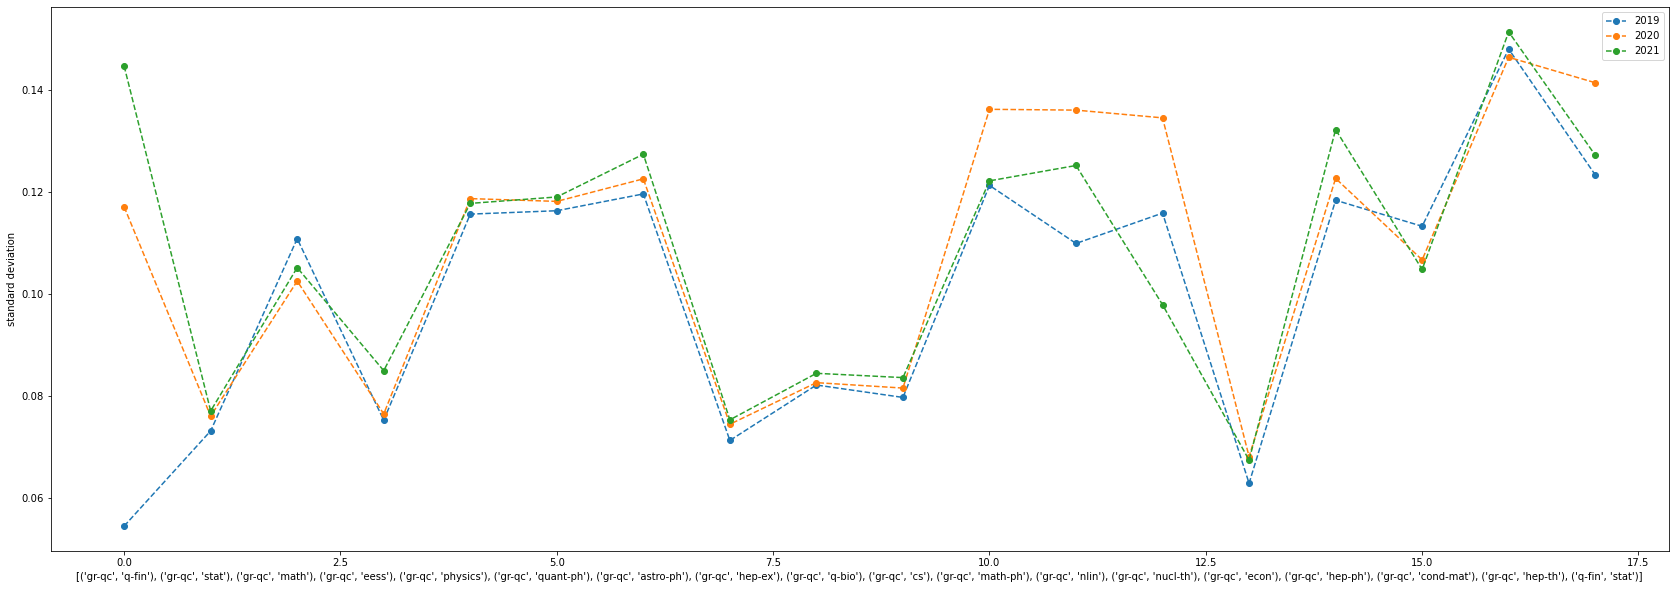

In [33]:
fig = plt.figure(figsize=(29,10))
x = np.arange(num)
for i in range(3):
    plt.plot(x,results_std[i],'o',linestyle='dashed')
plt.xlabel(list_2[:num])
plt.ylabel('standard deviation')
plt.legend(np.arange(2019,2022))
plt.show()